In [1]:
import os 
import pandas as pd 
import torch 
import torch.nn as nn 
import numpy as np 
import networkx as nx 
from torch_geometric.data import InMemoryDataset, Data
# from prep_mhealth import prep_mhealth
# from prep_wisdm import prep_wisdm
from torch.nn import Linear 
import torch.optim as optim 
from torch_geometric.nn import GCNConv
import time
import tqdm 
import random
import copy
from torch_geometric.data import DataLoader
# from model_utils import * 
import datetime as dttm 
import argparse
from mlflow import log_metric, log_param, log_artifacts
import mlflow 

In [2]:
os.getcwd()
os.chdir('../scripts')
from prep_mhealth import prep_mhealth
from prep_wisdm import prep_wisdm
from model_utils import * 
os.chdir('../')

In [3]:
os.getcwd()

'c:\\Users\\abhi\\Documents\\GEEK\\GNN\\ours'

In [5]:
from matplotlib import pyplot as plt 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def train(data, criterion):
    model.train()
    optimizer.zero_grad()  
    out = model(data.x, data.edge_index)
    y = data.y.squeeze().t() - 1
    loss = criterion(out[data.train_mask], y[data.train_mask]  ) 
    accuracy = torch.mean((torch.argmax(out[~data.train_mask] , 1) == y[~data.train_mask]).float())
    loss.backward() 
    optimizer.step()  
    return loss

def evaluate(data, test= True): 
        model.eval()
        y = data.y.squeeze().t() - 1
        out = model(data.x, data.edge_index)  

        if test: 
            accuracy = torch.mean((torch.argmax(out[~data.train_mask] , 1) == y[~data.train_mask]).float())
        else: 
            accuracy = torch.mean((torch.argmax(out[data.train_mask] , 1) == y[data.train_mask]).float())
        
        return accuracy

In [7]:
class GCN_wisdm(torch.nn.Module):
    def __init__(self, input_dim, num_class):
        super(GCN_wisdm, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, 512)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, num_class)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # Apply a final (linear) classifier.
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)

        return h

In [8]:
num_class = 6
input_dim = 3
BATCH_SIZE = 8
DATADIR  = 'data/processed/wisdm'
dataset  = HARDataCentral(DATADIR)
model = GCN_wisdm(input_dim, num_class)
loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle = True)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [9]:
model

GCN_wisdm(
  (conv1): GCNConv(3, 512)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
EPOCHS = 250
metrics = []
for epoch in tqdm.tqdm(range(EPOCHS)):
    for i, batch_ in enumerate(loader): 
        loss_ = train(batch, loss)  

    counter = 1
    val_acc = 0 
    trn_acc = 0 
    for each_data in dataset: 
        trn_acc += evaluate(each_data, test = False).item()
        val_acc += evaluate(each_data, test = True).item()
        counter += 1
    
    trn_accuracy = trn_acc / counter
    val_accuracy = val_acc / counter

    metrics.append((trn_accuracy, val_accuracy))
    
    if epoch % 10 == 0:
        print('epoch  :{0}, Train accuracy: {1}, Validation accuracy: {2}'.format(epoch, trn_accuracy, val_accuracy))
    
    # plt.plot(metrics)
    # plt.legend(['train', 'val'])

  0%|          | 0/250 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [25]:
metrics = []
for i in tqdm.tqdm(range(len(dataset))):
    # print('Agent: {0}\n'.format(i))
    EPOCHS = 50

    for epoch in range(EPOCHS):
        loss_ = train(dataset[i], loss)  

    trn_acc = evaluate(dataset[i], test = False).item()
    val_acc = evaluate(dataset[i], test = True).item()
    metrics.append((trn_acc, val_acc))        

100%|██████████| 36/36 [06:12<00:00, 10.36s/it]


In [26]:
metrics

[(0.695652186870575, 0.6891891956329346),
 (0.8121827244758606, 0.7763158082962036),
 (0.7727272510528564, 0.7777777910232544),
 (0.792553186416626, 0.6470588445663452),
 (0.6585366129875183, 0.658823549747467),
 (0.6809523701667786, 0.6292135119438171),
 (0.8838709592819214, 0.892307698726654),
 (0.8534482717514038, 0.8181818127632141),
 (0.7039999961853027, 0.6666666865348816),
 (0.7777777910232544, 0.7558139562606812),
 (0.7714285850524902, 0.7909091114997864),
 (0.9927007555961609, 0.936170220375061),
 (0.7882736325263977, 0.7279411554336548),
 (0.6898396015167236, 0.7111111283302307),
 (0.6271186470985413, 0.6491228342056274),
 (0.9057971239089966, 0.9047619104385376),
 (0.7400000095367432, 0.7884615659713745),
 (0.6933333277702332, 0.6451612710952759),
 (0.7777777910232544, 0.746666669845581),
 (0.7351351380348206, 0.7528089880943298),
 (0.7906976938247681, 0.7631579041481018),
 (0.7581395506858826, 0.773809552192688),
 (0.6544502377510071, 0.6309523582458496),
 (0.89130437374114

epoch  :49, Train accuracy: 0.42758793967801173, Validation accuracy: 0.435500974993448


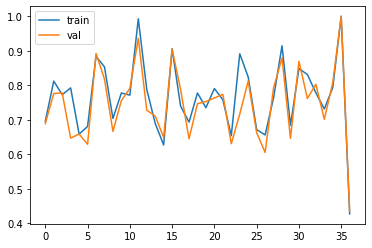

In [27]:
counter = 1
val_acc = 0 
trn_acc = 0 
for each_data in dataset: 
    trn_acc += evaluate(each_data, test = False).item()
    val_acc += evaluate(each_data, test = True).item()
    counter += 1

trn_accuracy = trn_acc / counter
val_accuracy = val_acc / counter

metrics.append((trn_accuracy, val_accuracy))


print('epoch  :{0}, Train accuracy: {1}, Validation accuracy: {2}'.format(epoch, trn_accuracy, val_accuracy))

plt.plot(metrics)
plt.legend(['train', 'val'])

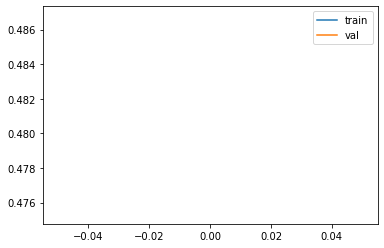

In [29]:
plt.plot(metrics)
plt.legend(['train', 'val'])


In [30]:
for data in dataset: 
    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('--')

Number of nodes: 235
Number of edges: 8138
Average node degree: 34.63
Number of training nodes: 161
Training node label rate: 0.69
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
--
Number of nodes: 273
Number of edges: 14536
Average node degree: 53.25
Number of training nodes: 197
Training node label rate: 0.72
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
--
Number of nodes: 248
Number of edges: 13446
Average node degree: 54.22
Number of training nodes: 176
Training node label rate: 0.71
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
--
Number of nodes: 256
Number of edges: 18748
Average node degree: 73.23
Number of training nodes: 188
Training node label rate: 0.73
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
--
Number of nodes: 290
Number of edges: 17990
Average node degree: 62.03
Number of training nodes: 205
Training node label rate: 0.71
Contains isolated 